In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn import svm
from sklearn import linear_model
import xgboost as xgb
import matplotlib.ticker
from sklearn import metrics
from sklearn import preprocessing

matplotlib.rcParams.update({'font.size': 16})
%matplotlib inline
pd.options.display.max_columns = 100

In [2]:
# df = pd.read_csv("data/block-groups.csv")
df = pd.read_csv("data/counties_US.csv")
#df = pd.read_csv("data/cities_US.csv") 

In [3]:
df.dropna(axis=0, how='any', inplace=True)
#print(df.iloc[0])
columns = df.columns
renames = {}
for col in columns:
    renames[col] = col.replace('-', '_')
df = df.rename(columns=renames)
df.describe()

,GEOID,year,population,poverty_rate,pct_renter_occupied,median_gross_rent,median_household_income,median_property_value,rent_burden,pct_white,pct_af_am,pct_hispanic,pct_am_ind,pct_asian,pct_nh_pi,pct_multiple,pct_other,renter_occupied_households,eviction_filings,evictions,eviction_rate,eviction_filing_rate,imputed,subbed
count,41299.000000,41299.000000,4.129900e+04,41299.000000,41299.000000,41299.000000,41299.000000,4.129900e+04,41299.000000,41299.000000,41299.000000,41299.000000,41299.000000,41299.000000,41299.000000,41299.000000,41299.000000,4.129900e+04,41299.000000,41299.000000,41299.000000,41299.000000,41299.000000,41299.000000
mean,30928.597956,2008.187753,9.717697e+04,12.410998,26.820699,592.652970,42136.557350,1.164624e+05,26.821584,79.966203,8.409063,7.861583,1.186445,0.994529,0.063298,1.431872,0.087025,1.301934e+04,892.026490,374.336449,1.678239,3.201757,0.014819,0.015860
std,14754.405831,4.819986,3.287348e+05,5.813251,7.648861,189.157504,11524.034138,7.300267e+04,4.754268,18.957256,14.113073,13.083396,4.495723,2.096220,0.611061,1.426454,0.150616,5.425438e+04,4419.432913,1543.484514,1.977446,5.027240,0.120828,0.124935
min,1001.000000,2000.000000,6.700000e+01,0.000000,7.350000,178.000000,9333.000000,0.000000e+00,8.300000,2.860000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,19089.000000,2004.000000,1.044500e+04,8.300000,21.740000,464.000000,34202.000000,7.470000e+04,23.600000,69.460000,0.420000,1.310000,0.140000,0.190000,0.000000,0.710000,0.000000,9.710000e+02,5.000000,3.000000,0.320000,0.490000,0.000000,0.000000
50%,29181.000000,2008.000000,2.351300e+04,11.460000,25.540000,571.000000,40657.000000,9.640000e+04,26.800000,87.330000,1.810000,2.810000,0.270000,0.430000,0.010000,1.130000,0.040000,2.315000e+03,37.000000,25.000000,1.110000,1.630000,0.000000,0.000000
75%,45086.000000,2012.000000,6.268300e+04,15.315000,30.430000,680.000000,48007.000000,1.363000e+05,29.800000,94.790000,9.250000,7.620000,0.580000,0.920000,0.040000,1.710000,0.110000,6.844500e+03,240.000000,140.000000,2.320000,3.800000,0.000000,0.000000
max,56045.000000,2016.000000,1.003839e+07,45.380000,100.000000,1827.000000,123453.000000,1.000001e+06,50.100000,100.000000,86.760000,95.680000,84.960000,45.260000,48.300000,23.490000,4.900000,1.792186e+06,143753.000000,47716.000000,24.160000,118.620000,1.000000,1.000000


In [4]:
df.head()

,GEOID,year,name,parent_location,population,poverty_rate,pct_renter_occupied,median_gross_rent,median_household_income,median_property_value,rent_burden,pct_white,pct_af_am,pct_hispanic,pct_am_ind,pct_asian,pct_nh_pi,pct_multiple,pct_other,renter_occupied_households,eviction_filings,evictions,eviction_rate,eviction_filing_rate,imputed,subbed
0,1001,2000,Autauga County,Alabama,43671.0,10.92,19.21,537.0,42013.0,94800.0,22.6,79.74,17.01,1.40,0.43,0.44,0.03,0.86,0.10,3074.0,61.0,40.0,1.30,1.98,0.0,0.0
1,1003,2000,Baldwin County,Alabama,140415.0,10.15,20.46,566.0,40250.0,122500.0,24.5,86.08,10.22,1.76,0.54,0.38,0.03,0.93,0.07,11320.0,213.0,65.0,0.57,1.88,0.0,0.0
2,1005,2000,Barbour County,Alabama,29038.0,26.80,26.87,333.0,25101.0,68600.0,25.1,50.93,46.04,1.65,0.41,0.29,0.02,0.66,0.01,2797.0,15.0,11.0,0.39,0.54,0.0,0.0
3,1007,2000,Bibb County,Alabama,20826.0,20.61,19.81,348.0,31420.0,74600.0,22.9,76.20,22.01,1.01,0.22,0.08,0.01,0.47,0.00,1470.0,13.0,8.0,0.54,0.88,0.0,0.0
5,1011,2000,Bullock County,Alabama,11714.0,33.48,25.51,324.0,20605.0,56600.0,35.1,23.60,72.44,2.75,0.32,0.18,0.01,0.66,0.05,1012.0,7.0,6.0,0.59,0.69,0.0,0.0


# Causal Inference: Using Propensity modeling to estimate race causal effect on evictions. 

Propensity score methods have become one of the most important tools for analyzing causal
effects in observational studies.

step 1: select features: 'poverty_rate','rent_burden','pct_renter_occupied','renter_occupied_households','median_gross_rent','median_household_income','median_property_value','state'

step 2: build a probabilistic model to predict the percentage of percentage of black race in a city, the predicted value is called propensity score.

step 3: divide the propensity scores into several buckets.

step 4: compare the correlation of eviction rates with percentage of back race within each buckets.

In [5]:
df_16 = df[df.year == 2016]
df_16.shape

(2493, 26)

In [6]:
df_16.reset_index(inplace = True)

# Investigate correlations of features

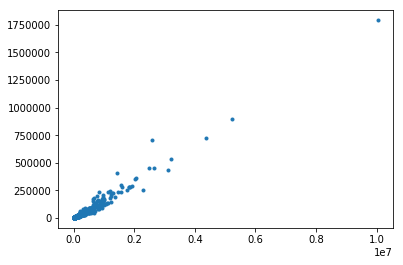

In [7]:
plt.plot(df_16.population, df_16.renter_occupied_households,'.')

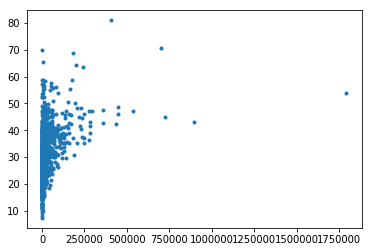

In [8]:
plt.plot(df_16.renter_occupied_households, df_16.pct_renter_occupied,'.')

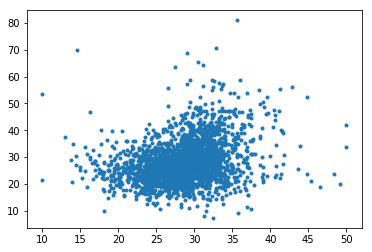

In [9]:
plt.plot(df_16.rent_burden, df_16.pct_renter_occupied,'.')

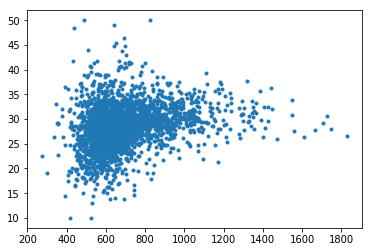

In [10]:
plt.plot(df_16.median_gross_rent, df_16.rent_burden,'.')

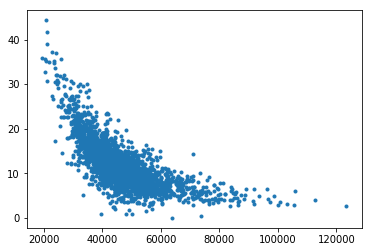

In [11]:
plt.plot(df_16.median_household_income, df_16.poverty_rate, '.')

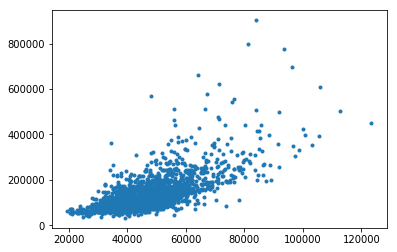

In [12]:
plt.plot(df_16.median_household_income, df_16.median_property_value,'.')

In [13]:
df_16dummy = pd.get_dummies(df_16.parent_location)

In [14]:
# df_16norm = pd.DataFrame(2000*preprocessing.normalize(df_16[['renter_occupied_households', 'median_gross_rent','median_household_income',\
#                                                             'median_property_value']], axis = 0), \
#                          columns = ['renter_occupied_households','median_gross_rent','median_household_income','median_property_value'])

# df_16[['poverty_rate','rent_burden','pct_renter_occupied']].shape

# #del X

# X = pd.concat([df_16[['poverty_rate','rent_burden','pct_renter_occupied']], df_16norm, df_16dummy], axis = 1)

In [15]:
df_16norm = pd.DataFrame(preprocessing.normalize(df_16[['poverty_rate','rent_burden','pct_renter_occupied','renter_occupied_households', 'median_gross_rent','median_household_income',\
                                                            'median_property_value']], axis = 0), \
                         columns = ['poverty_rate','rent_burden','pct_renter_occupied','renter_occupied_households','median_gross_rent','median_household_income','median_property_value'])

X = pd.concat([df_16norm, df_16dummy], axis = 1)


In [16]:
#np.finfo(float).eps

In [17]:
#del df_16

In [18]:
#df_16 = df_16.copy()
#df_16.loc[df_16.pct_af_am == 0 , 'pct_af_am'] = np.finfo(float).eps


In [19]:
#df_16.loc[df_16.pct_af_am == 1 , 'pct_af_am'] = 1+np.finfo(float).eps

In [20]:
df_16.pct_af_am.describe()

count    2493.000000
mean        8.639996
std        14.175599
min         0.000000
25%         0.560000
50%         2.030000
75%         9.550000
max        85.950000
Name: pct_af_am, dtype: float64

In [21]:
#y = df_16['pct_af_am'].apply(lambda x: np.log(x/(1.-x)))

In [22]:
#y = df_16['pct_af_am'].apply(lambda x: np.log(x/(100-x)))

In [23]:
y = df_16['pct_af_am']

In [24]:
model = xgb.XGBRegressor(max_depth=6, learning_rate=0.5, n_estimators=100, silent=True, objective='reg:linear',\
                         booster='gbtree', n_jobs=1, nthread=None, gamma=0, min_child_weight=1, max_delta_step=0,\
                         subsample=1, colsample_bytree=1, colsample_bylevel=1, reg_alpha=0, reg_lambda=1, \
                         scale_pos_weight=1, base_score=0.5, random_state=0, seed=None, missing=None)

In [25]:
#xgb.XGBRegressor?

In [26]:
# model = linear_model.SGDRegressor(loss='squared_epsilon_insensitive', penalty='elasticnet', alpha=0.0001, l1_ratio=0.15,\
#                                   fit_intercept=True,max_iter=6000, tol=None, shuffle=True, verbose=0, epsilon=0.1, \
#                                   random_state=42, learning_rate='invscaling', eta0=0.0001, power_t=0.25, \
#                                   warm_start=False,average=False)

In [27]:
#model = linear_model.LinearRegression()
model.fit(X,y)
y_pred = model.predict(X)

metrics.explained_variance_score(y, y_pred)

0.9980999669639864

In [28]:
#linear_model.SGDRegressor?

In [29]:
metrics.r2_score(y, y_pred)

0.998099966863387

(array([845., 524., 223., 128.,  84.,  76.,  65.,  38.,  44.,  34.,  32.,
         35.,  24.,  20.,  29.,  25.,  18.,  25.,  17.,  19.,  20.,  13.,
         17.,  10.,  16.,  11.,  10.,  11.,   9.,   6.,   7.,   4.,   7.,
          5.,   8.,   5.,   2.,   3.,   2.,   1.,   5.,   6.,   1.,   3.,
          2.,   0.,   2.,   0.,   1.,   1.]),
 array([-0.67446256,  1.06185995,  2.79818245,  4.53450495,  6.27082746,
         8.00714996,  9.74347246, 11.47979496, 13.21611747, 14.95243997,
        16.68876247, 18.42508498, 20.16140748, 21.89772998, 23.63405249,
        25.37037499, 27.10669749, 28.84302   , 30.5793425 , 32.315665  ,
        34.0519875 , 35.78831001, 37.52463251, 39.26095501, 40.99727752,
        42.73360002, 44.46992252, 46.20624503, 47.94256753, 49.67889003,
        51.41521254, 53.15153504, 54.88785754, 56.62418005, 58.36050255,
        60.09682505, 61.83314755, 63.56947006, 65.30579256, 67.04211506,
        68.77843757, 70.51476007, 72.25108257, 73.98740508, 75.72372758,
 

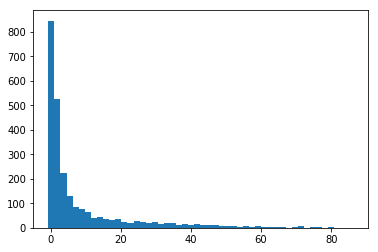

In [30]:
plt.hist(y_pred,bins = 50 )

(array([1.182e+03, 2.820e+02, 1.730e+02, 1.110e+02, 7.400e+01, 7.100e+01,
        6.000e+01, 4.100e+01, 3.700e+01, 2.800e+01, 4.000e+01, 3.300e+01,
        2.100e+01, 2.400e+01, 3.100e+01, 1.700e+01, 2.100e+01, 2.600e+01,
        1.800e+01, 1.900e+01, 1.700e+01, 1.300e+01, 1.900e+01, 7.000e+00,
        1.800e+01, 1.000e+01, 8.000e+00, 9.000e+00, 1.200e+01, 5.000e+00,
        8.000e+00, 2.000e+00, 9.000e+00, 6.000e+00, 6.000e+00, 3.000e+00,
        6.000e+00, 2.000e+00, 2.000e+00, 1.000e+00, 4.000e+00, 7.000e+00,
        2.000e+00, 2.000e+00, 2.000e+00, 0.000e+00, 1.000e+00, 1.000e+00,
        1.000e+00, 1.000e+00]),
 array([ 0.   ,  1.719,  3.438,  5.157,  6.876,  8.595, 10.314, 12.033,
        13.752, 15.471, 17.19 , 18.909, 20.628, 22.347, 24.066, 25.785,
        27.504, 29.223, 30.942, 32.661, 34.38 , 36.099, 37.818, 39.537,
        41.256, 42.975, 44.694, 46.413, 48.132, 49.851, 51.57 , 53.289,
        55.008, 56.727, 58.446, 60.165, 61.884, 63.603, 65.322, 67.041,
        68.76 , 

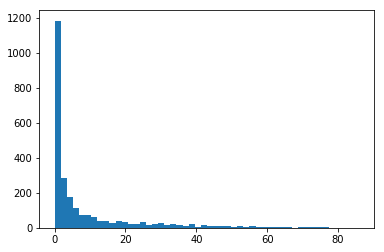

In [31]:
plt.hist(y, bins = 50)

In [32]:
y_pred.size

2493

In [33]:
#bukets width = 5
df_y_pred = pd.DataFrame(y_pred, columns = {'y_pred'})

In [34]:
df_16.reset_index(drop = True, inplace = True)

In [35]:
df_p = pd.concat([df_16, df_y_pred], axis = 1)

array([[1.        , 0.37540872],
       [0.37540872, 1.        ]])

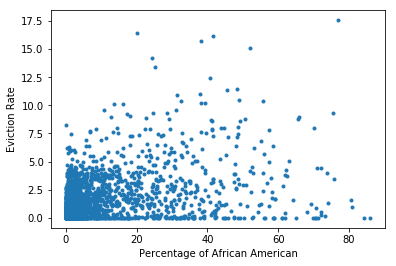

In [36]:
plt.plot(df_p.pct_af_am, df_p.eviction_rate,'.')
plt.xlabel('Percentage of African American')
plt.ylabel('Eviction Rate')
np.corrcoef(df_p.pct_af_am, df_p.eviction_rate)

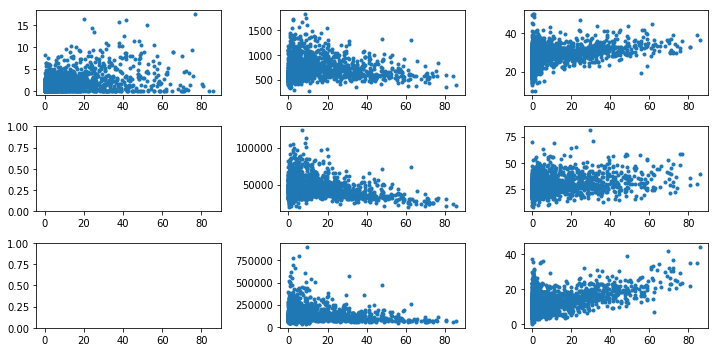

In [37]:

fig, ((ax1, ax2, ax3), (ax4, ax5, ax6), (ax7, ax8, ax9)) = plt.subplots(3,3, figsize=(10,5), sharex='row')
ax1.plot(df_16.pct_af_am, df_16.eviction_rate,'.')

ax2.plot(df_16.pct_af_am, df_16.median_gross_rent, '.')
ax3.plot(df_16.pct_af_am, df_16.rent_burden, '.')
ax5.plot(df_16.pct_af_am, df_16.median_household_income, '.')

ax6.plot(df_16.pct_af_am, df_16.pct_renter_occupied, '.')
ax8.plot(df_16.pct_af_am, df_16.median_property_value, '.')
ax9.plot(df_16.pct_af_am, df_16.poverty_rate, '.')

plt.tight_layout()


In [38]:
np.corrcoef([df_16.pct_af_am, df_16.eviction_rate,df_16.median_gross_rent, df_16.rent_burden,\
             df_16.median_household_income, df_16.pct_renter_occupied, df_16.median_property_value,\
             df_16.poverty_rate])[0]

array([ 1.        ,  0.37540872,  0.04596906,  0.35152739, -0.25884827,
        0.30675884, -0.08630837,  0.50951121])

# correlation of pct_af_am and eviction rates within buckets

## bucket of predicted pct_af_am of < 1%  has high correlation

## bucket of predicted black-race-percentage <= 0.5

array([ 1.        ,  0.1824601 ,  0.05595222,  0.22007686,  0.01171619,
       -0.02543839,  0.07488983,  0.00872129])

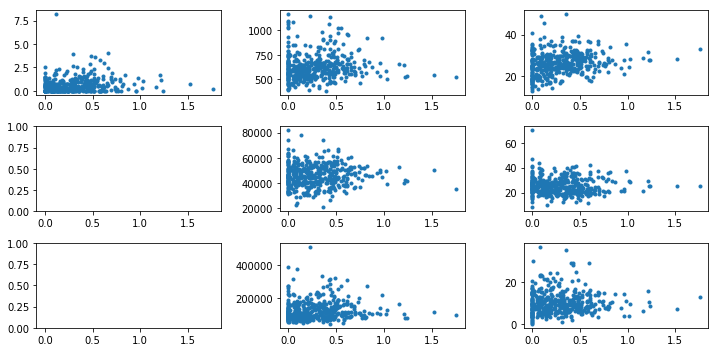

In [39]:
df_10 = df_p[(df_p.y_pred <= 0.5)]

fig, ((ax1, ax2, ax3), (ax4, ax5, ax6), (ax7, ax8, ax9)) = plt.subplots(3,3, figsize=(10,5), sharex='row')
ax1.plot(df_10.pct_af_am, df_10.eviction_rate,'.')

ax2.plot(df_10.pct_af_am, df_10.median_gross_rent, '.')
ax3.plot(df_10.pct_af_am, df_10.rent_burden, '.')
ax5.plot(df_10.pct_af_am, df_10.median_household_income, '.')

ax6.plot(df_10.pct_af_am, df_10.pct_renter_occupied, '.')
ax8.plot(df_10.pct_af_am, df_10.median_property_value, '.')
ax9.plot(df_10.pct_af_am, df_10.poverty_rate, '.')

plt.tight_layout()

np.corrcoef([df_10.pct_af_am, df_10.eviction_rate,df_10.median_gross_rent, df_10.rent_burden,\
             df_10.median_household_income, df_10.pct_renter_occupied, df_10.median_property_value,\
             df_10.poverty_rate])[0]

## bucket of predicted black-race-percentage (0.5, 1]

array([ 1.        ,  0.11146696,  0.09238938,  0.04932082,  0.09399575,
        0.09348859,  0.08892346, -0.0212685 ])

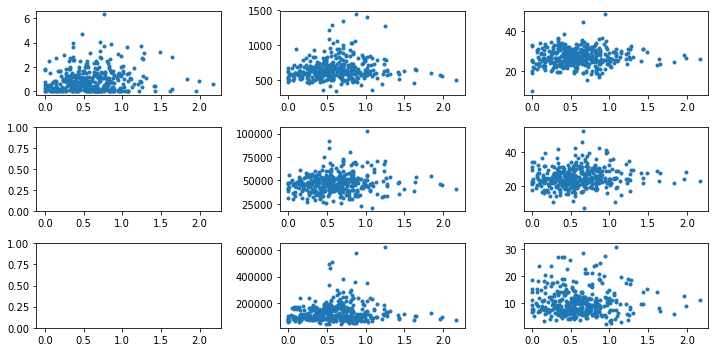

In [40]:
df_10 = df_p[(df_p.y_pred > .5) & (df_p.y_pred <= 1)]

fig, ((ax1, ax2, ax3), (ax4, ax5, ax6), (ax7, ax8, ax9)) = plt.subplots(3,3, figsize=(10,5), sharex='row')
ax1.plot(df_10.pct_af_am, df_10.eviction_rate,'.')

ax2.plot(df_10.pct_af_am, df_10.median_gross_rent, '.')
ax3.plot(df_10.pct_af_am, df_10.rent_burden, '.')
ax5.plot(df_10.pct_af_am, df_10.median_household_income, '.')

ax6.plot(df_10.pct_af_am, df_10.pct_renter_occupied, '.')
ax8.plot(df_10.pct_af_am, df_10.median_property_value, '.')
ax9.plot(df_10.pct_af_am, df_10.poverty_rate, '.')

plt.tight_layout()

np.corrcoef([df_10.pct_af_am, df_10.eviction_rate,df_10.median_gross_rent, df_10.rent_burden,\
             df_10.median_household_income, df_10.pct_renter_occupied, df_10.median_property_value, \
             df_10.poverty_rate])[0]

## bucket of predicted black-race-percentage (1, 5]

array([1.        , 0.0714252 , 0.11528813, 0.07601134, 0.03638695,
       0.12387165, 0.03845003, 0.04877244])

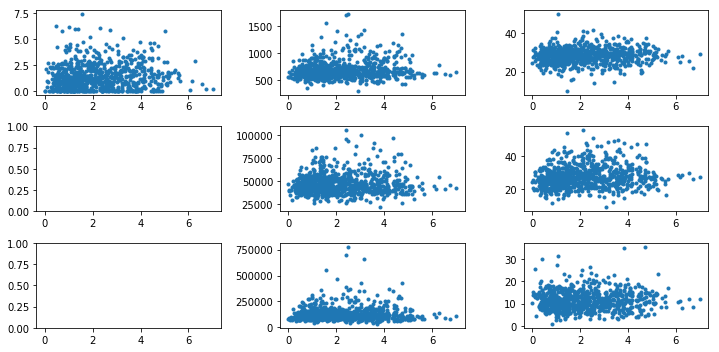

In [41]:
df_10 = df_p[(df_p.y_pred > 1) & (df_p.y_pred <= 5)]

fig, ((ax1, ax2, ax3), (ax4, ax5, ax6), (ax7, ax8, ax9)) = plt.subplots(3,3, figsize=(10,5), sharex='row')
ax1.plot(df_10.pct_af_am, df_10.eviction_rate,'.')

ax2.plot(df_10.pct_af_am, df_10.median_gross_rent, '.')
ax3.plot(df_10.pct_af_am, df_10.rent_burden, '.')
ax5.plot(df_10.pct_af_am, df_10.median_household_income, '.')

ax6.plot(df_10.pct_af_am, df_10.pct_renter_occupied, '.')
ax8.plot(df_10.pct_af_am, df_10.median_property_value, '.')
ax9.plot(df_10.pct_af_am, df_10.poverty_rate, '.')

plt.tight_layout()

np.corrcoef([df_10.pct_af_am, df_10.eviction_rate,df_10.median_gross_rent, df_10.rent_burden,\
             df_10.median_household_income, df_10.pct_renter_occupied, df_10.median_property_value, \
             df_10.poverty_rate])[0]

## bucket of predicted black-race-percentage (5, 10]

array([ 1.        , -0.01217197, -0.00617623,  0.04694456, -0.019619  ,
       -0.01746704, -0.00518995,  0.02837812])

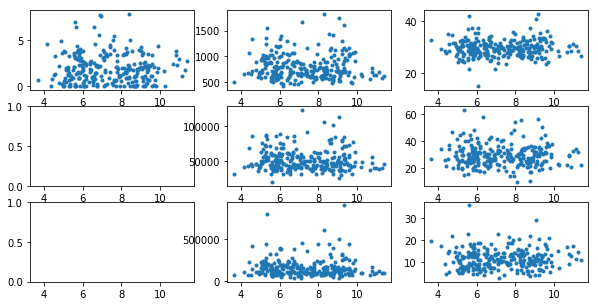

In [42]:
df_10 = df_p[(df_p.y_pred > 5) & (df_p.y_pred <= 10)]

fig, ((ax1, ax2, ax3), (ax4, ax5, ax6), (ax7, ax8, ax9)) = plt.subplots(3,3, figsize=(10,5), sharex='row')
ax1.plot(df_10.pct_af_am, df_10.eviction_rate,'.')

ax2.plot(df_10.pct_af_am, df_10.median_gross_rent, '.')
ax3.plot(df_10.pct_af_am, df_10.rent_burden, '.')
ax5.plot(df_10.pct_af_am, df_10.median_household_income, '.')

ax6.plot(df_10.pct_af_am, df_10.pct_renter_occupied, '.')
ax8.plot(df_10.pct_af_am, df_10.median_property_value, '.')
ax9.plot(df_10.pct_af_am, df_10.poverty_rate, '.')


np.corrcoef([df_10.pct_af_am, df_10.eviction_rate,df_10.median_gross_rent, df_10.rent_burden,\
             df_10.median_household_income, df_10.pct_renter_occupied, df_10.median_property_value, \
             df_10.poverty_rate])[0]

## bucket of predicted black-race-percentage (10, 20]

array([ 1.        ,  0.03173978,  0.02017166, -0.04383174,  0.01557254,
       -0.02629626, -0.02995587,  0.04468589])

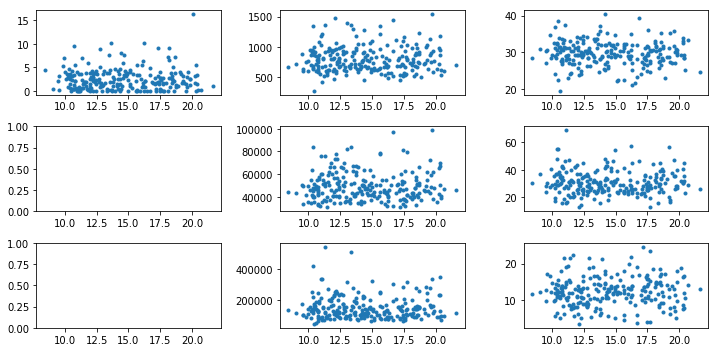

In [43]:
df_10 = df_p[(df_p.y_pred > 10) & (df_p.y_pred <= 20)]
fig, ((ax1, ax2, ax3), (ax4, ax5, ax6), (ax7, ax8, ax9)) = plt.subplots(3,3, figsize=(10,5), sharex='row')
ax1.plot(df_10.pct_af_am, df_10.eviction_rate,'.')

ax2.plot(df_10.pct_af_am, df_10.median_gross_rent, '.')
ax3.plot(df_10.pct_af_am, df_10.rent_burden, '.')
ax5.plot(df_10.pct_af_am, df_10.median_household_income, '.')

ax6.plot(df_10.pct_af_am, df_10.pct_renter_occupied, '.')
ax8.plot(df_10.pct_af_am, df_10.median_property_value, '.')
ax9.plot(df_10.pct_af_am, df_10.poverty_rate, '.')
plt.tight_layout()

np.corrcoef([df_10.pct_af_am, df_10.eviction_rate,df_10.median_gross_rent, df_10.rent_burden,\
             df_10.median_household_income, df_10.pct_renter_occupied, df_10.median_property_value,\
             df_10.poverty_rate])[0]

## bucket of predicted black-race-percentage (20,30]

array([ 1.        ,  0.05308549, -0.11344714,  0.03339661, -0.15610378,
        0.05260499, -0.04112884,  0.19882068])

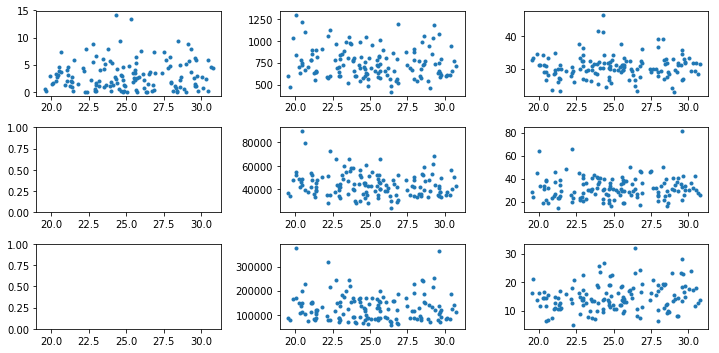

In [44]:

df_10 = df_p[(df_p.y_pred > 20) & (df_p.y_pred <= 30)]

fig, ((ax1, ax2, ax3), (ax4, ax5, ax6), (ax7, ax8, ax9)) = plt.subplots(3,3, figsize=(10,5), sharex='row')
ax1.plot(df_10.pct_af_am, df_10.eviction_rate,'.')

ax2.plot(df_10.pct_af_am, df_10.median_gross_rent, '.')
ax3.plot(df_10.pct_af_am, df_10.rent_burden, '.')
ax5.plot(df_10.pct_af_am, df_10.median_household_income, '.')

ax6.plot(df_10.pct_af_am, df_10.pct_renter_occupied, '.')
ax8.plot(df_10.pct_af_am, df_10.median_property_value, '.')
ax9.plot(df_10.pct_af_am, df_10.poverty_rate, '.')
plt.tight_layout()

np.corrcoef([df_10.pct_af_am, df_10.eviction_rate,df_10.median_gross_rent, df_10.rent_burden,\
             df_10.median_household_income, df_10.pct_renter_occupied, df_10.median_property_value,\
             df_10.poverty_rate])[0]

   ## bucket of predicted black-race-percentage (30, 40]  has higher correlation

array([ 1.        ,  0.13832433,  0.01854265,  0.13618926,  0.01891658,
        0.09869172, -0.0033383 ,  0.12573548])

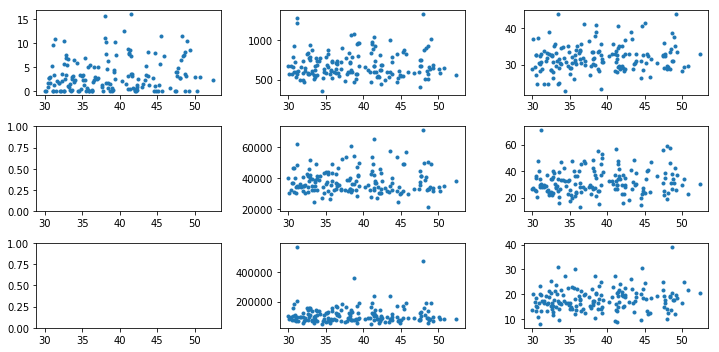

In [45]:
df_10 = df_p[(df_p.y_pred > 30) & (df_p.y_pred <= 50)]

fig, ((ax1, ax2, ax3), (ax4, ax5, ax6), (ax7, ax8, ax9)) = plt.subplots(3,3, figsize=(10,5), sharex='row')
ax1.plot(df_10.pct_af_am, df_10.eviction_rate,'.')

ax2.plot(df_10.pct_af_am, df_10.median_gross_rent, '.')
ax3.plot(df_10.pct_af_am, df_10.rent_burden, '.')
ax5.plot(df_10.pct_af_am, df_10.median_household_income, '.')

ax6.plot(df_10.pct_af_am, df_10.pct_renter_occupied, '.')
ax8.plot(df_10.pct_af_am, df_10.median_property_value, '.')
ax9.plot(df_10.pct_af_am, df_10.poverty_rate, '.')

plt.tight_layout()

np.corrcoef([df_10.pct_af_am, df_10.eviction_rate,df_10.median_gross_rent, df_10.rent_burden,\
             df_10.median_household_income, df_10.pct_renter_occupied, df_10.median_property_value,\
             df_10.poverty_rate])[0]

## bucket of predicted black-race-percentage (50,100]

array([ 1.        , -0.08577344, -0.26284113,  0.05793828, -0.38960917,
        0.14917251, -0.3067337 ,  0.55457192])

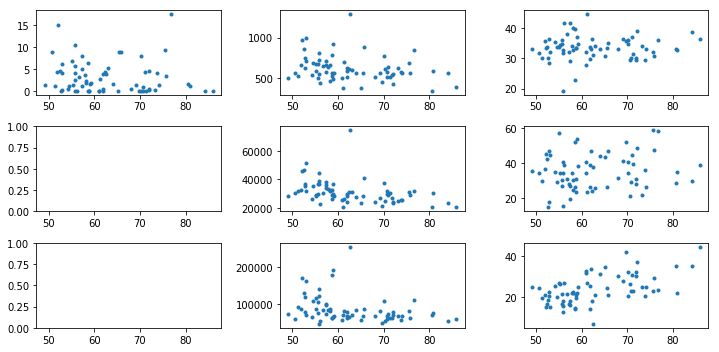

In [46]:
df_10 = df_p[(df_p.y_pred > 50)]
fig, ((ax1, ax2, ax3), (ax4, ax5, ax6), (ax7, ax8, ax9)) = plt.subplots(3,3, figsize=(10,5), sharex='row')
ax1.plot(df_10.pct_af_am, df_10.eviction_rate,'.')

ax2.plot(df_10.pct_af_am, df_10.median_gross_rent, '.')
ax3.plot(df_10.pct_af_am, df_10.rent_burden, '.')
ax5.plot(df_10.pct_af_am, df_10.median_household_income, '.')

ax6.plot(df_10.pct_af_am, df_10.pct_renter_occupied, '.')
ax8.plot(df_10.pct_af_am, df_10.median_property_value, '.')
ax9.plot(df_10.pct_af_am, df_10.poverty_rate, '.')

plt.tight_layout()

np.corrcoef([df_10.pct_af_am, df_10.eviction_rate,df_10.median_gross_rent, df_10.rent_burden,\
             df_10.median_household_income, df_10.pct_renter_occupied, df_10.median_property_value,\
             df_10.poverty_rate])[0]